<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [4]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible randomization

#####
# 1) Generate blinded sequence pools (5 codes each)
#####
def gen_sequences(condition: str, count: int = 5) -> list:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 2) Load & filter pre-screen
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

# read full pre-screen
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)

# 2a) exclude anyone marked excluded
df = df[df['excluded'].str.strip().str.lower() == 'false'].copy()

# 2b) only keep those with calendly_event_booked == TRUE or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked']
      .fillna('')
      .str.strip()
      .str.lower()
)
df = df[
    df['calendly_event_booked_clean']
      .isin(['true', 'none_available'])
].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# 2c) compute PHQ-9 sum and bin into strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')

def phq9_bin(x):
    if 5 <= x <= 16:
        return 'low'
    if 17 <= x <= 27:
        return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin) + '_' +
    df['incl_dem_med'].str.strip().str.lower()
)
# drop any rows that didn't land in a valid stratum
df = df[df['stratum'].str.contains("_")].copy()

# keep track of original order for sequence assignment
df['_order'] = df.reset_index().index

#####
# 3) Load existing assignments (if any)
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

#####
# 4) Identify new participants & assign conditions
#####
assigned = existing[['part_id','stratum','condition']]
merged = df[['part_id','stratum','_order']].merge(
    assigned, on=['part_id','stratum'], how='left'
)

# mark new vs. already-assigned
merged['is_new'] = merged['condition'].isna()

def assign_block(idx: int, stratum: str) -> str:
    rng = random.Random() if SEED is None else random.Random(
        int(hashlib.sha256(f"{SEED}-{stratum}-{idx//BLOCK_SIZE}".encode()).hexdigest(), 16)
    )
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: r['condition']
              if pd.notna(r['condition'])
              else assign_block(assigned.shape[0] + r.name, r['stratum']),
    axis=1
)

#####
# 5) Assign sequence names globally
#####
# sort by original order
merged = merged.sort_values('_order')

# running index per condition
merged['seq_idx'] = merged.groupby('condition').cumcount()

# map to one of the 5-code pools
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 6) Output results
#####
# 6a) save the full assignments
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

# 6b) print only the newly‐assigned participants
new_out = merged[merged['is_new']][['part_id','sequence_name']]
print(new_out)

Empty DataFrame
Columns: [part_id, sequence_name]
Index: []


# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations




In [3]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded code pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]

INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)

# strip whitespace from column names & IDs
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].astype(str).str.strip()

# (a) exclude anyone marked excluded==FALSE
df = df[df['excluded'].astype(str).str.strip().str.lower() == 'false'].copy()

# (b) only those who booked or none_available
df['calendly_event_booked_clean'] = (
    df['calendly_event_booked']
      .fillna('')
      .str.strip()
      .str.lower()
)
df = df[df['calendly_event_booked_clean'].isin(['true','none_available'])].copy()
df.drop(columns=['calendly_event_booked_clean'], inplace=True)

# (c) PHQ-9 strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df['stratum'] = (
    df['phq9_sum'].apply(phq9_bin).fillna('') + '_' +
    df['incl_dem_med'].astype(str).str.strip().str.lower()
)
df = df[df['stratum'].str.contains("_")].copy()

# keep original order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments (if any)
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns     = existing.columns.str.strip()
    existing['part_id']  = existing['part_id'].astype(str).str.strip()
    existing['condition']= existing['condition'].astype(str).str.strip()
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])

assigned = existing[['part_id','stratum','condition']].copy()
base_idx = len(assigned)

#####
# 5) Merge in to see who’s new
#####
merged = df[['part_id','stratum','_order']].merge(
    assigned, on=['part_id','stratum'], how='left'
).reset_index(drop=True)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Block‐randomize any new participants
#####
def assign_block(idx: int, stratum: str) -> str:
    seed_int = None if SEED is None else int(
        hashlib.sha256(f"{SEED}-{stratum}-{idx//BLOCK_SIZE}".encode()).hexdigest(), 16
    )
    rng = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]

merged['condition'] = merged.apply(
    lambda r: r['condition']
              if pd.notna(r['condition'])
              else assign_block(base_idx + r.name, r['stratum']),
    axis=1
)

#####
# 7) Assign sequence codes globally
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(
    lambda r: (
        INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)]
        if r.condition == 'intervention'
        else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]
    ),
    axis=1
)

#####
# 8) Save & print debug
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)

print("▶︎ Assignment counts by arm:")
print(full['condition'].value_counts(), "\n")

print("▶︎ Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

▶︎ Assignment counts by arm:
condition
control         8
intervention    5
Name: count, dtype: int64 

▶︎ Newly assigned participants:
   part_id sequence_name
0    11143    WP2-E98EF1
1    11310    WP2-6E363F
2    11165    WP2-FE09EA
3    11329    WP2-7F6D87
4    11275    WP2-FC4114
5    11369    WP2-0BDE7F
6    11227    WP2-C4546D
7    11354    WP2-6E363F
8    11255    WP2-641C50
9    11216    WP2-FE09EA
10   11154    WP2-3EB089
11   11113    WP2-FC4114
12   11402    WP2-032756


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [24]:
#####
# 9) Blind stratification check
#####
# new_out already contains only current-run participants (computed above)
new_count = len(new_out)
if new_count >= BLOCK_SIZE:
    # Prompt only when full BLOCK_SIZE of new participants present
    if new_count == BLOCK_SIZE:
        prompt = "At least one new block has been added. Would you like to proceed? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Assessing stratification balance may result in unblinding. "
            "Are you sure you would like to proceed? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y', 'yes'):
        # Prepare blind summary without unblinding individual codes
        summary = (
            full
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check")
        print(summary)
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 0 new participants added (< 4); skipping stratification check.


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script









── phq9_sum  |  Condition: control ──


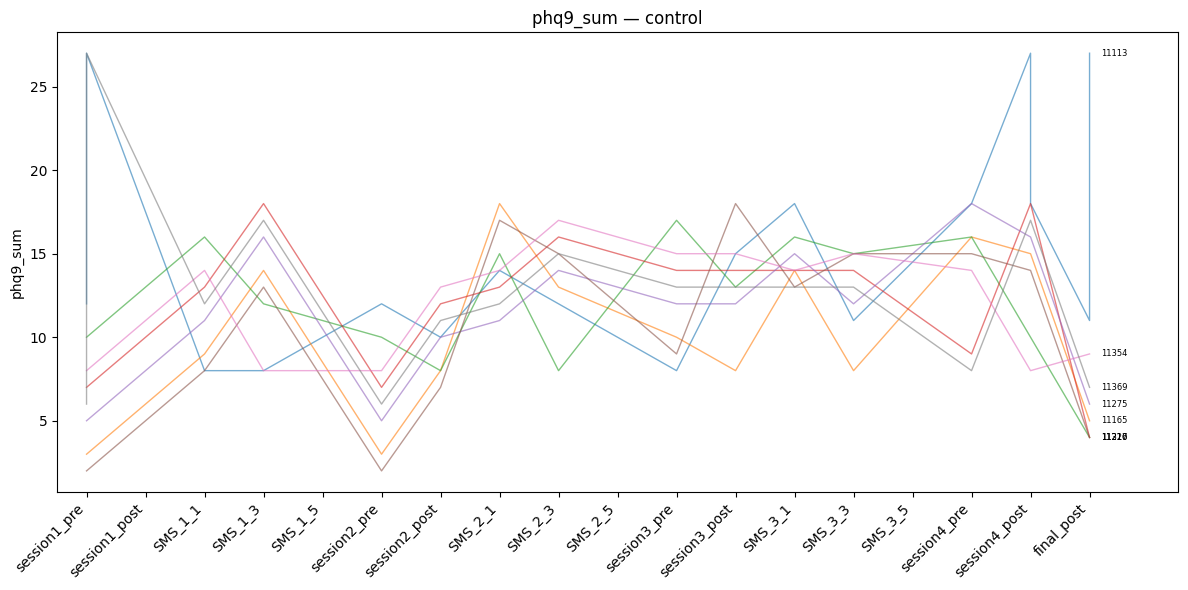

Worsened trajectories:


,part_id,timepoint,phq9_sum
0,11113,session1_pre,12.0
1,11113,session1_pre,27.0
2,11113,SMS_1_1,8.0
3,11113,SMS_1_3,8.0
4,11113,session2_pre,12.0
...,...,...,...
101,11369,session4_post,17.0
102,11369,final_post,7.0
103,11369,NaN,11.0
104,11369,NaN,15.0



── phq9_sum  |  Condition: intervention ──


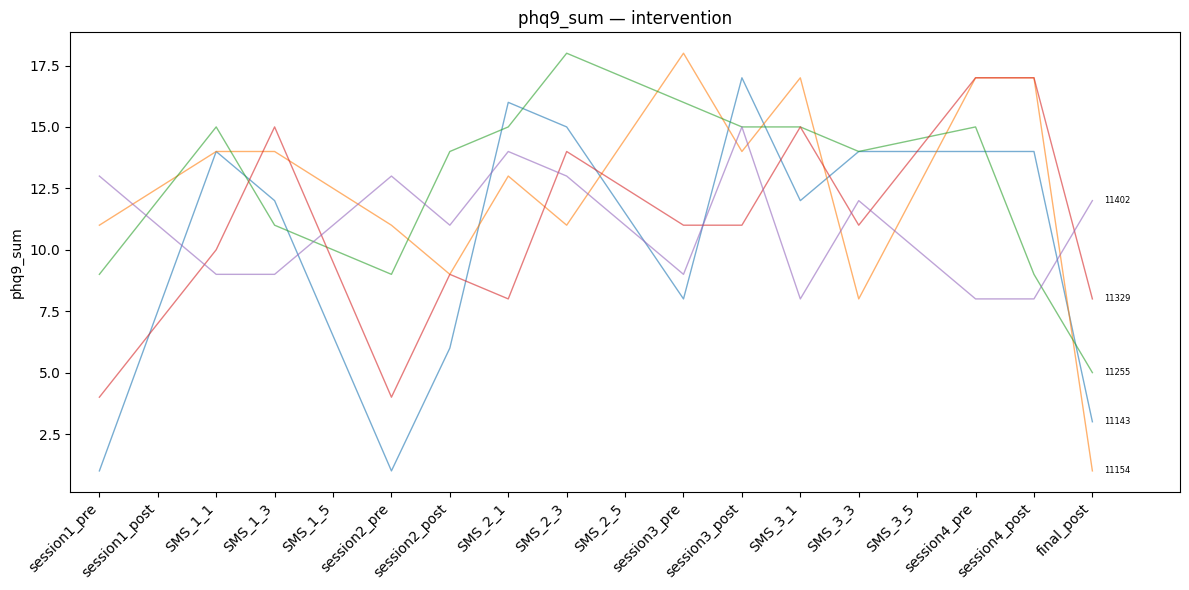

Worsened trajectories:


,part_id,timepoint,phq9_sum
0,11143,session1_pre,1.0
1,11143,SMS_1_1,14.0
2,11143,SMS_1_3,12.0
3,11143,session2_pre,1.0
4,11143,session2_post,6.0
5,11143,SMS_2_1,16.0
6,11143,SMS_2_3,15.0
7,11143,session3_pre,8.0
8,11143,session3_post,17.0
9,11143,SMS_3_1,12.0



── spane_p  |  Condition: control ──


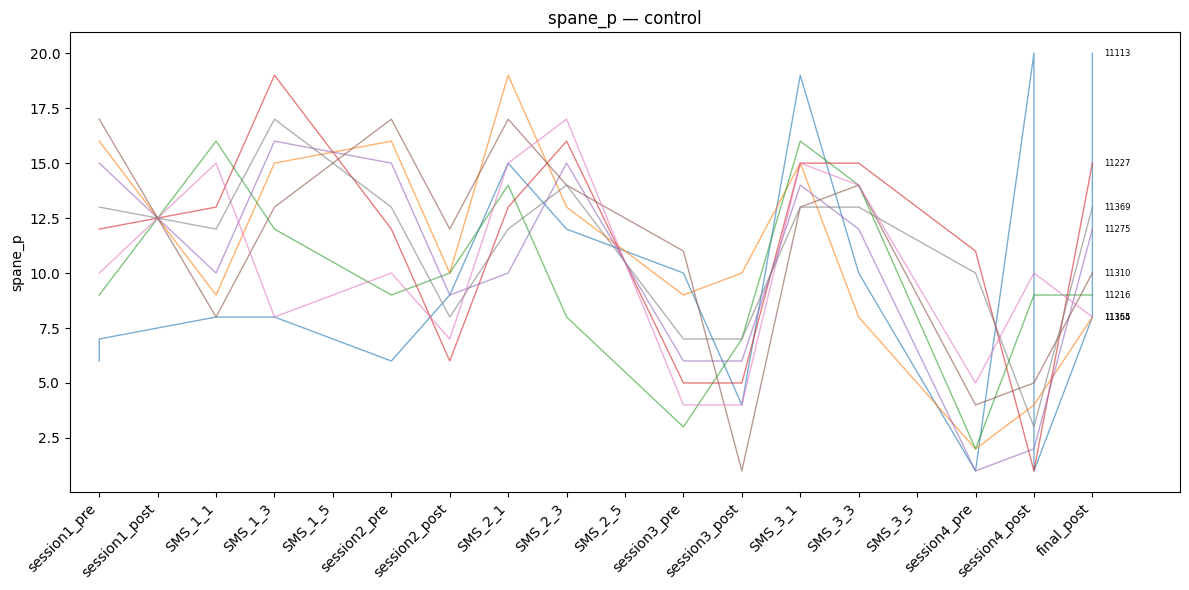

Worsened trajectories:


,part_id,timepoint,spane_p
0,11165,session1_pre,16.0
1,11165,SMS_1_1,9.0
2,11165,SMS_1_3,15.0
3,11165,session2_pre,16.0
4,11165,session2_post,10.0
...,...,...,...
63,11354,session4_post,10.0
64,11354,final_post,8.0
65,11354,NaN,13.0
66,11354,NaN,10.0



── spane_p  |  Condition: intervention ──


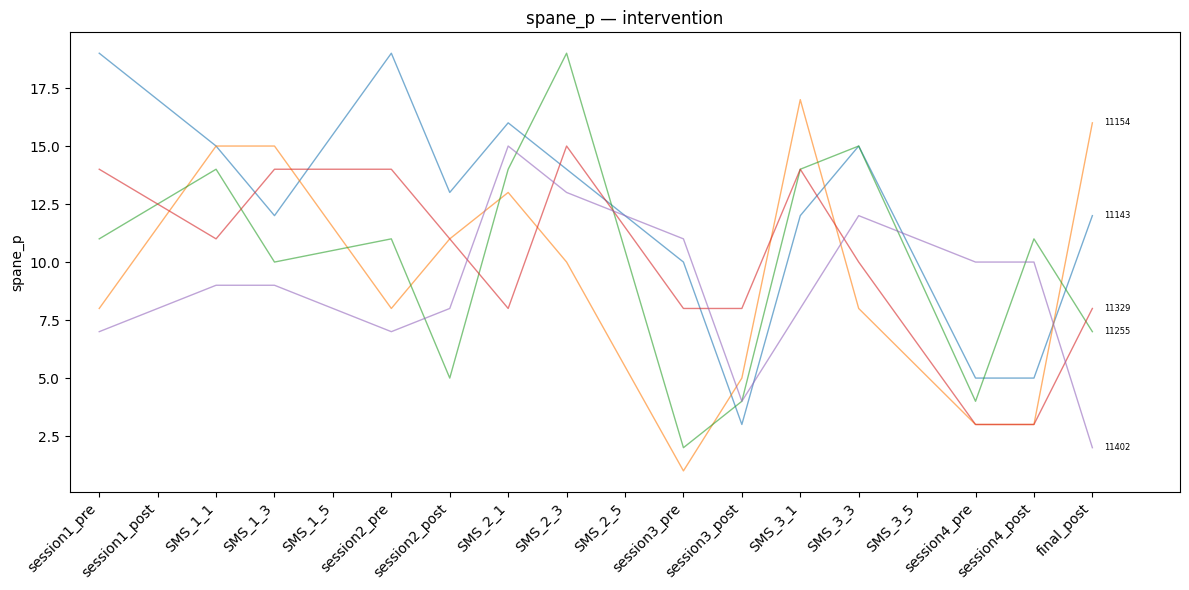

Worsened trajectories:


,part_id,timepoint,spane_p
0,11143,session1_pre,19.0
1,11143,SMS_1_1,15.0
2,11143,SMS_1_3,12.0
3,11143,session2_pre,19.0
4,11143,session2_post,13.0
...,...,...,...
63,11402,session4_post,10.0
64,11402,final_post,2.0
65,11402,NaN,15.0
66,11402,NaN,19.0



── spane_n  |  Condition: control ──


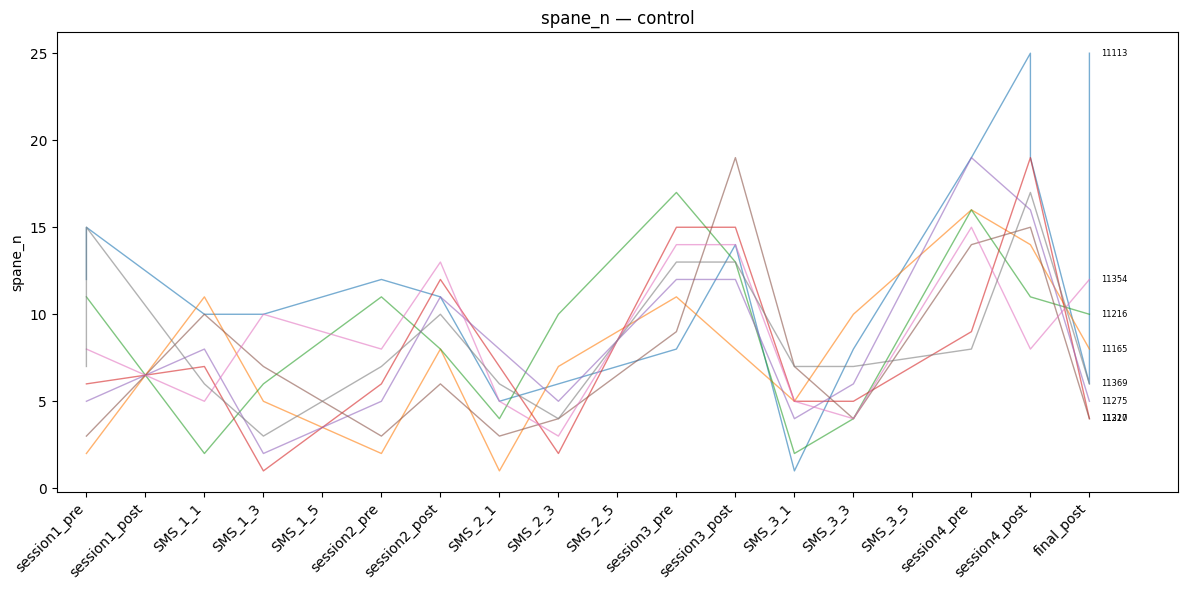

Worsened trajectories:


,part_id,timepoint,spane_n
0,11113,session1_pre,12.0
1,11113,session1_pre,15.0
2,11113,SMS_1_1,10.0
3,11113,SMS_1_3,10.0
4,11113,session2_pre,12.0
...,...,...,...
66,11354,session4_post,8.0
67,11354,final_post,12.0
68,11354,NaN,7.0
69,11354,NaN,8.0



── spane_n  |  Condition: intervention ──


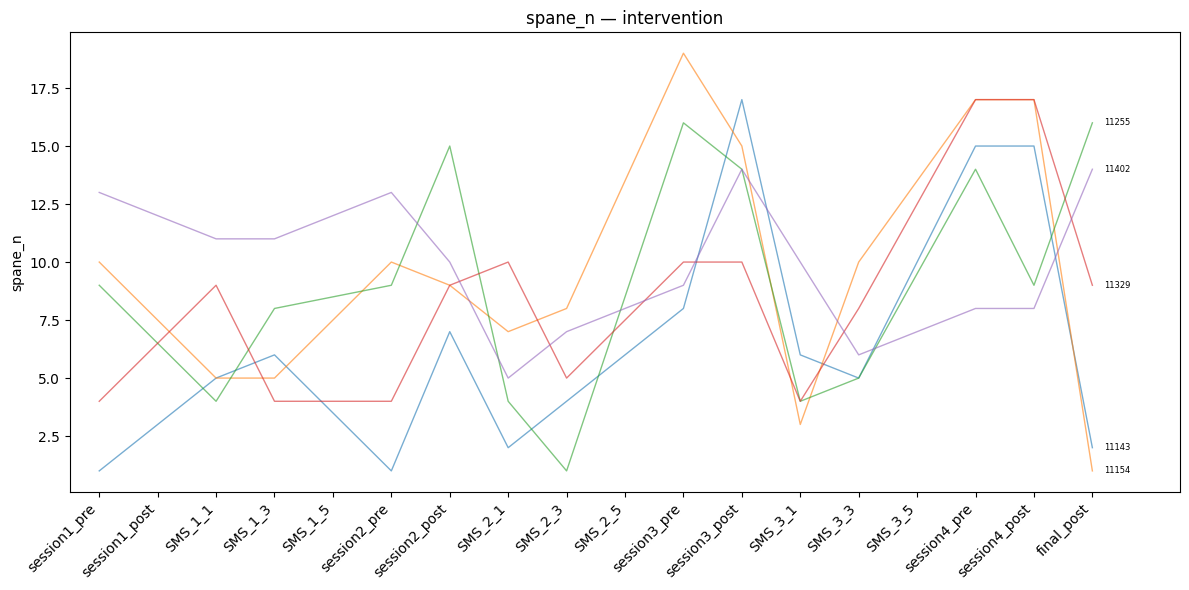

Worsened trajectories:


,part_id,timepoint,spane_n
0,11143,session1_pre,1.0
1,11143,SMS_1_1,5.0
2,11143,SMS_1_3,6.0
3,11143,session2_pre,1.0
4,11143,session2_post,7.0
...,...,...,...
63,11402,session4_post,8.0
64,11402,final_post,14.0
65,11402,NaN,5.0
66,11402,NaN,1.0



── m3vas_mood  |  Condition: control ──


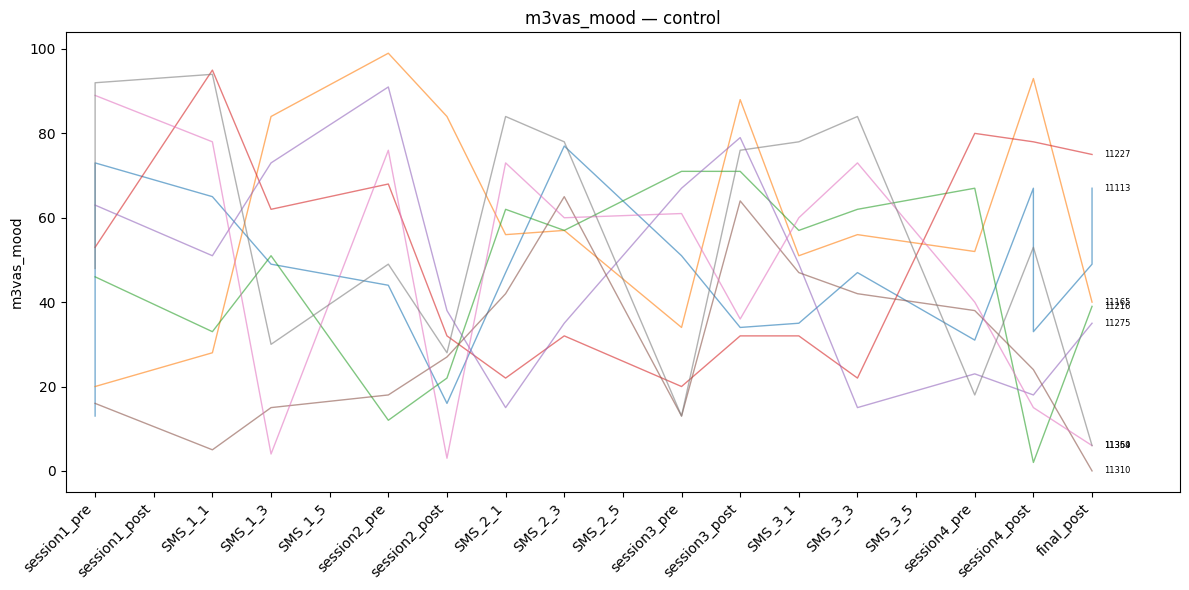

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11216,session1_pre,46.0
1,11216,SMS_1_1,33.0
2,11216,SMS_1_3,51.0
3,11216,session2_pre,12.0
4,11216,session2_post,22.0
...,...,...,...
81,11369,session4_post,53.0
82,11369,final_post,6.0
83,11369,NaN,9.0
84,11369,NaN,15.0



── m3vas_mood  |  Condition: intervention ──


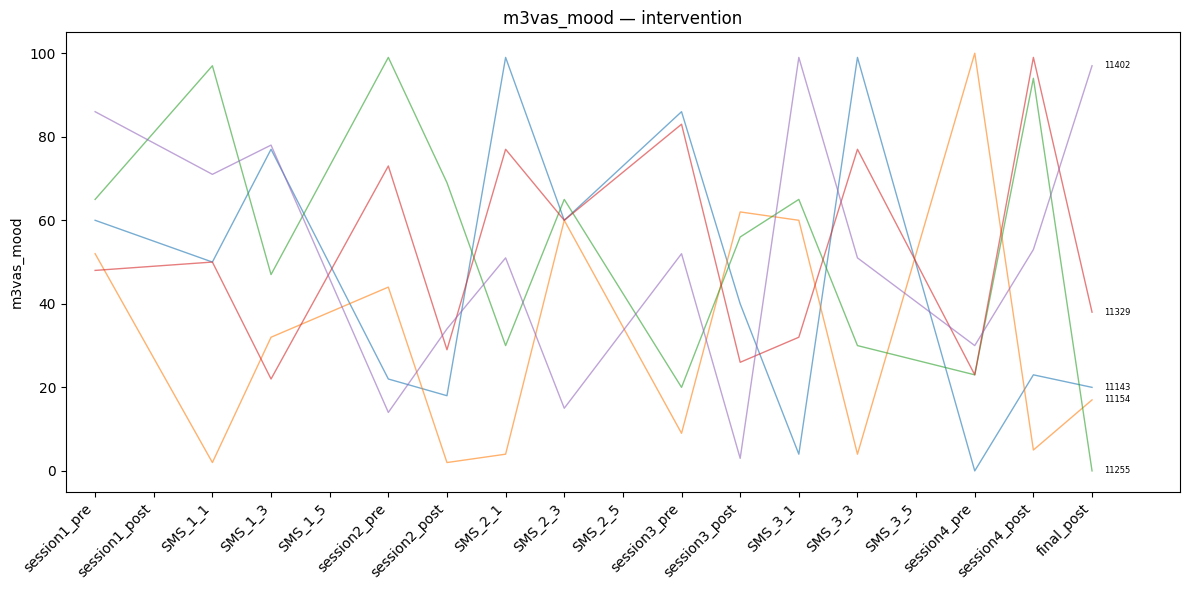

Worsened trajectories:


,part_id,timepoint,m3vas_mood
0,11143,session1_pre,60.0
1,11143,SMS_1_1,50.0
2,11143,SMS_1_3,77.0
3,11143,session2_pre,22.0
4,11143,session2_post,18.0
...,...,...,...
63,11329,session4_post,99.0
64,11329,final_post,38.0
65,11329,NaN,5.0
66,11329,NaN,60.0



── m3vas_pleasure  |  Condition: control ──


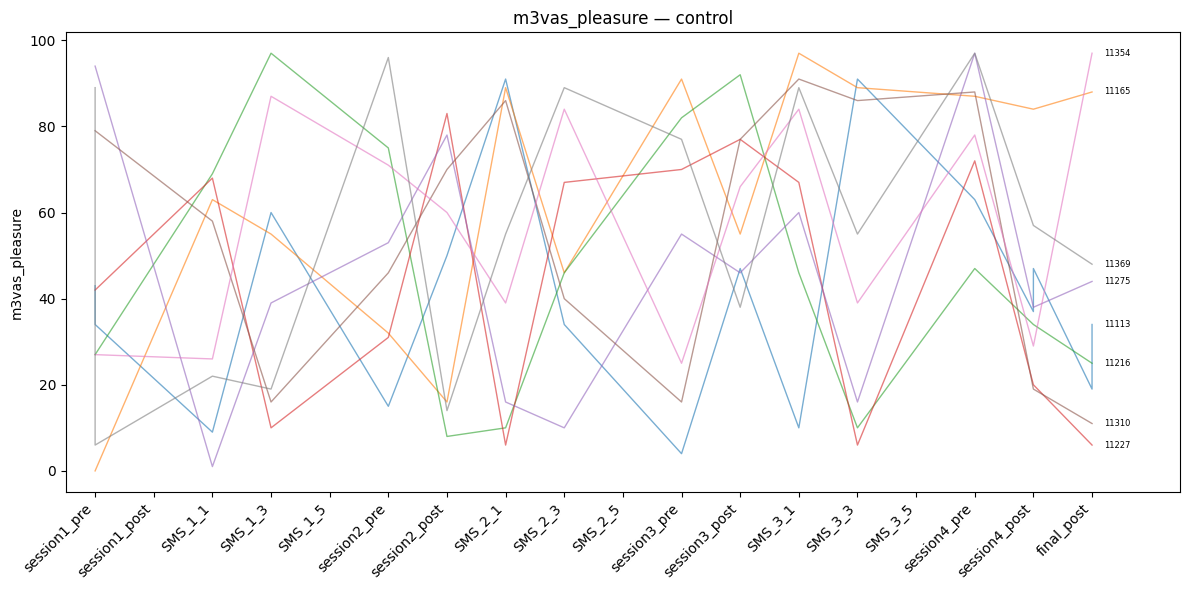

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11113,session1_pre,43.0
1,11113,session1_pre,34.0
2,11113,SMS_1_1,9.0
3,11113,SMS_1_3,60.0
4,11113,session2_pre,15.0
...,...,...,...
101,11369,session4_post,57.0
102,11369,final_post,48.0
103,11369,NaN,46.0
104,11369,NaN,16.0



── m3vas_pleasure  |  Condition: intervention ──


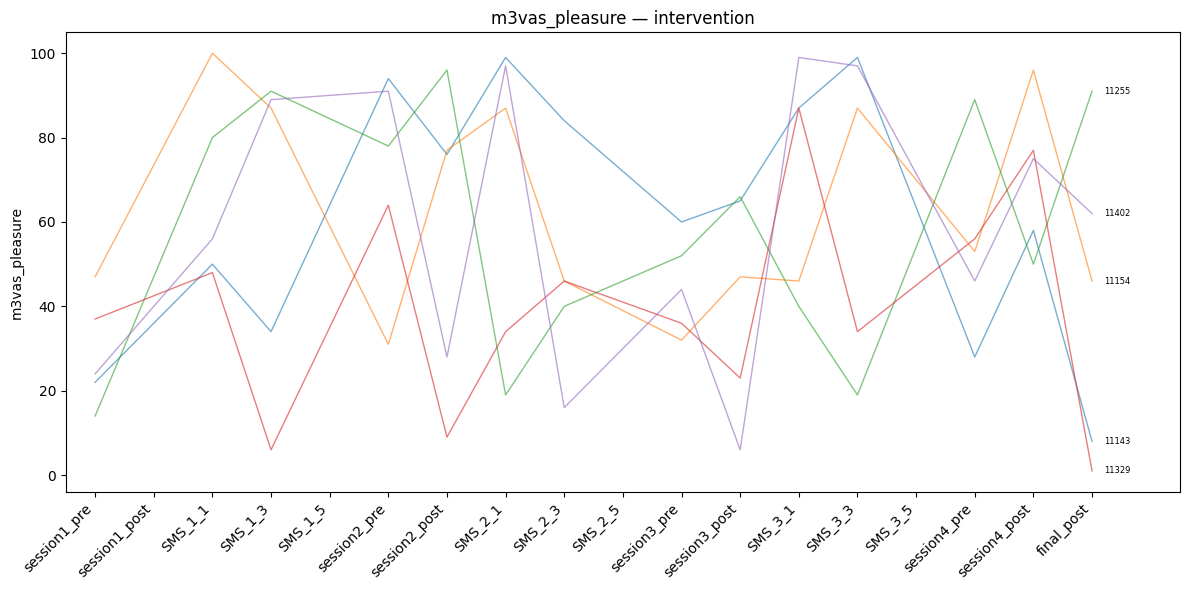

Worsened trajectories:


,part_id,timepoint,m3vas_pleasure
0,11143,session1_pre,22.0
1,11143,SMS_1_1,50.0
2,11143,SMS_1_3,34.0
3,11143,session2_pre,94.0
4,11143,session2_post,76.0
5,11143,SMS_2_1,99.0
6,11143,SMS_2_3,84.0
7,11143,session3_pre,60.0
8,11143,session3_post,65.0
9,11143,SMS_3_1,87.0



── m3vas_suicidal  |  Condition: control ──


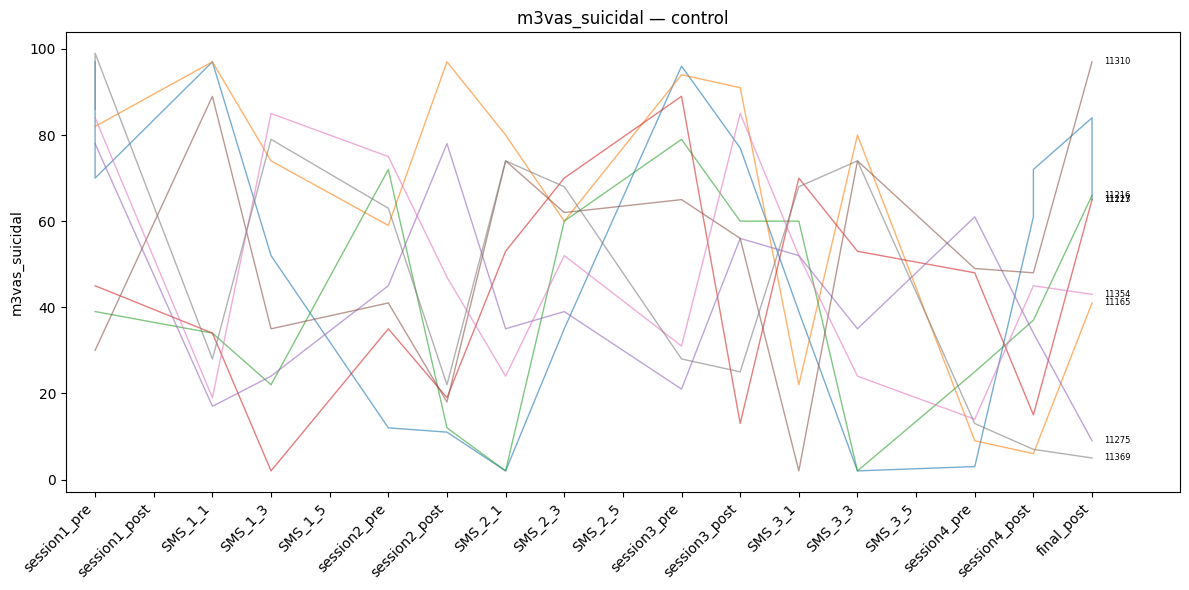

Worsened trajectories:


,part_id,timepoint,m3vas_suicidal
0,11216,session1_pre,39.0
1,11216,SMS_1_1,34.0
2,11216,SMS_1_3,22.0
3,11216,session2_pre,72.0
4,11216,session2_post,12.0
5,11216,SMS_2_1,2.0
6,11216,SMS_2_3,60.0
7,11216,session3_pre,79.0
8,11216,session3_post,60.0
9,11216,SMS_3_1,60.0



── m3vas_suicidal  |  Condition: intervention ──


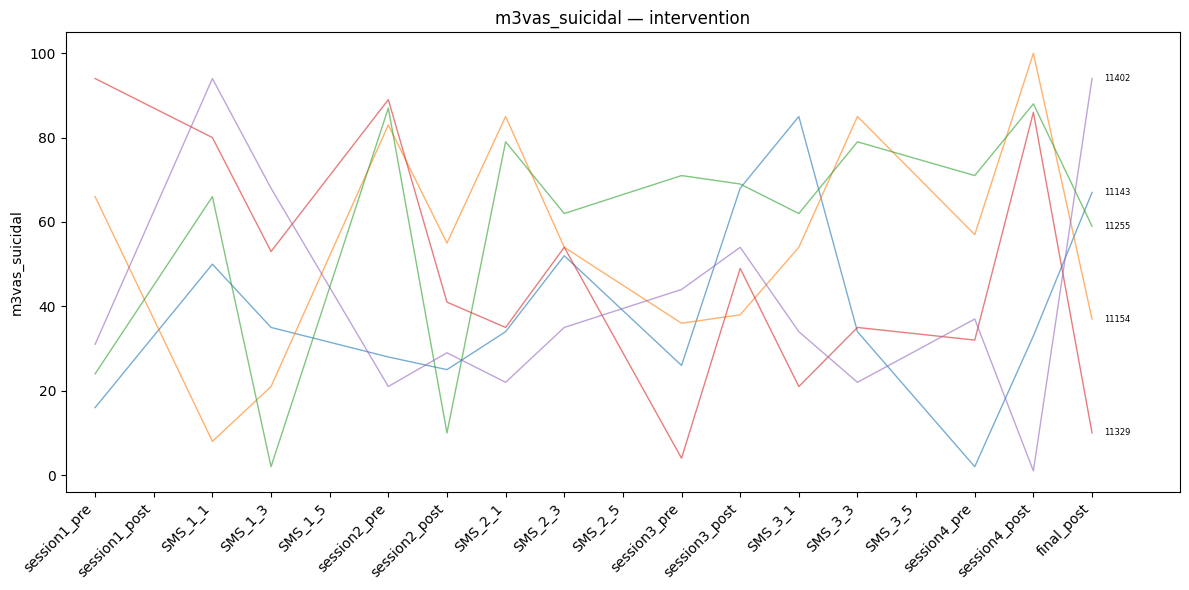

Worsened trajectories:


,part_id,timepoint,m3vas_suicidal
0,11143,session1_pre,16.0
1,11143,SMS_1_1,50.0
2,11143,SMS_1_3,35.0
3,11143,session2_pre,28.0
4,11143,session2_post,25.0
5,11143,SMS_2_1,34.0
6,11143,SMS_2_3,52.0
7,11143,session3_pre,26.0
8,11143,session3_post,68.0
9,11143,SMS_3_1,85.0



── fisber_1  |  Condition: control ──


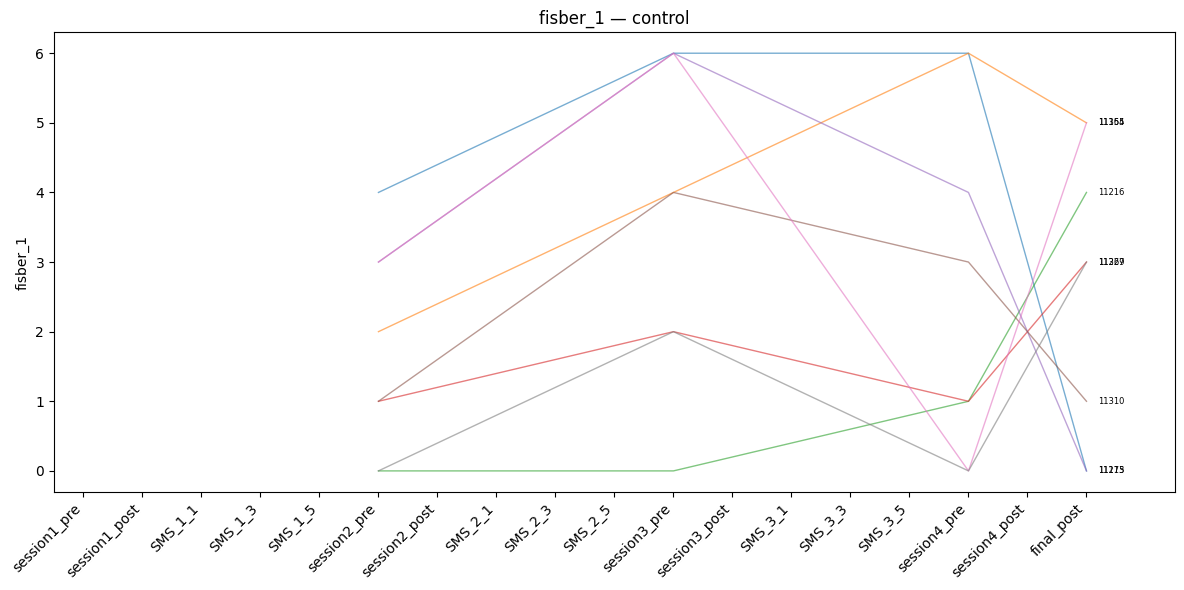

Worsened trajectories:


,part_id,timepoint,fisber_1
0,11165,session2_pre,2.0
1,11165,session3_pre,4.0
2,11165,session4_pre,6.0
3,11165,final_post,5.0
4,11216,session2_pre,0.0
5,11216,session3_pre,0.0
6,11216,session4_pre,1.0
7,11216,final_post,4.0
8,11227,session2_pre,1.0
9,11227,session3_pre,2.0



── fisber_1  |  Condition: intervention ──


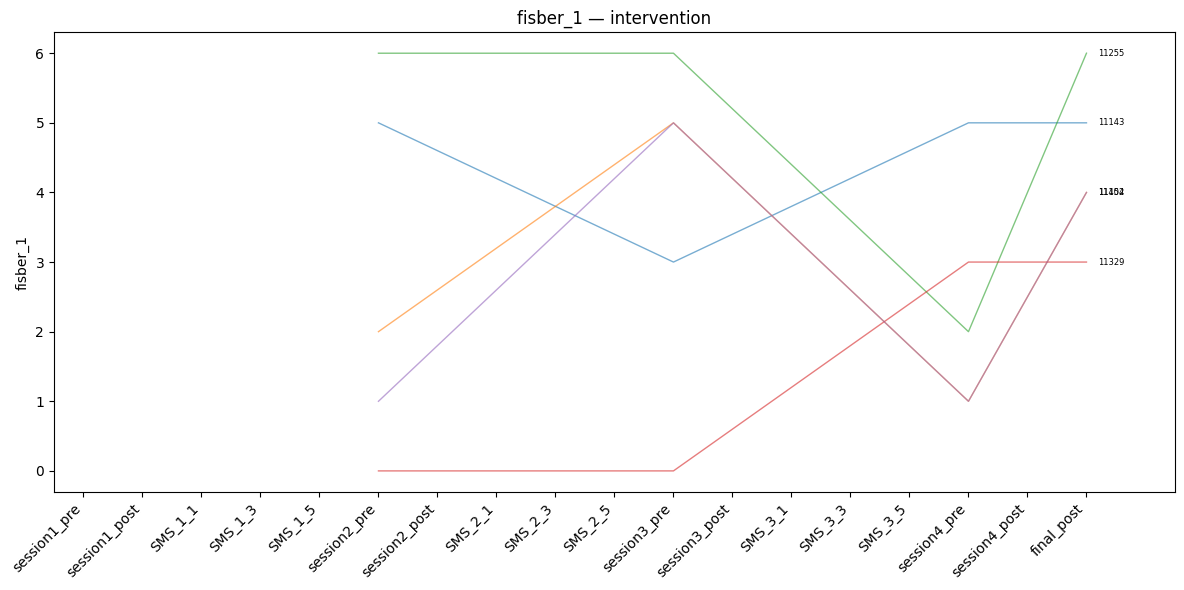

Worsened trajectories:


,part_id,timepoint,fisber_1
0,11154,session2_pre,2.0
1,11154,session3_pre,5.0
2,11154,session4_pre,1.0
3,11154,final_post,4.0
4,11329,session2_pre,0.0
5,11329,session3_pre,0.0
6,11329,session4_pre,3.0
7,11329,final_post,3.0
8,11402,session2_pre,1.0
9,11402,session3_pre,5.0



── fisber_2  |  Condition: control ──


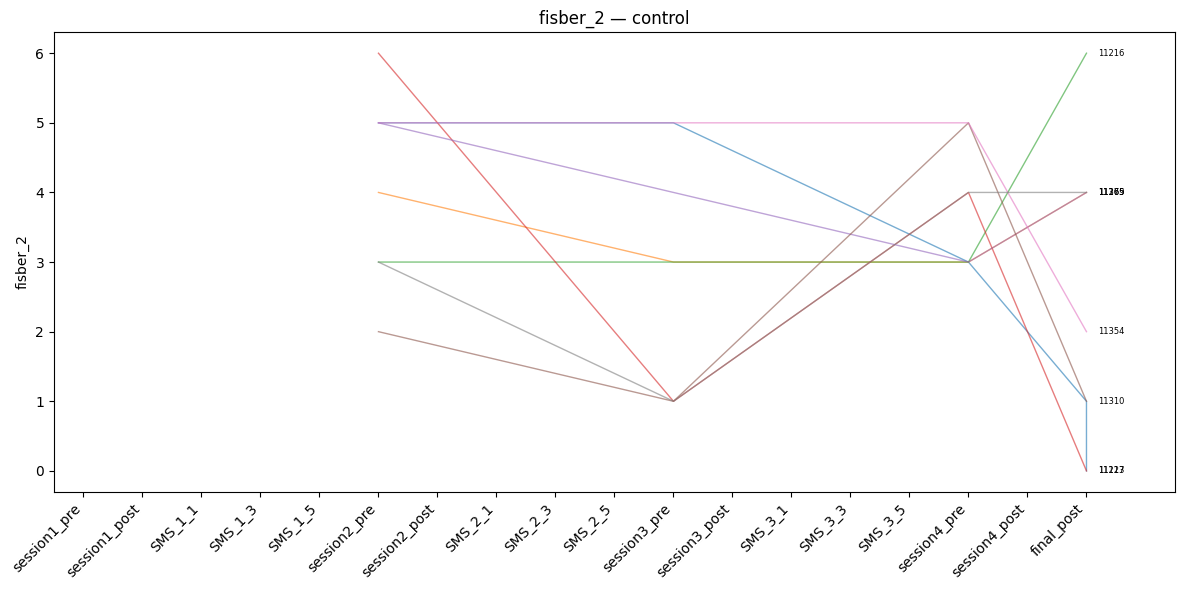

Worsened trajectories:


,part_id,timepoint,fisber_2
0,11216,session2_pre,3.0
1,11216,session3_pre,3.0
2,11216,session4_pre,3.0
3,11216,final_post,6.0
4,11369,session2_pre,3.0
5,11369,session3_pre,1.0
6,11369,session4_pre,4.0
7,11369,final_post,4.0



── fisber_2  |  Condition: intervention ──


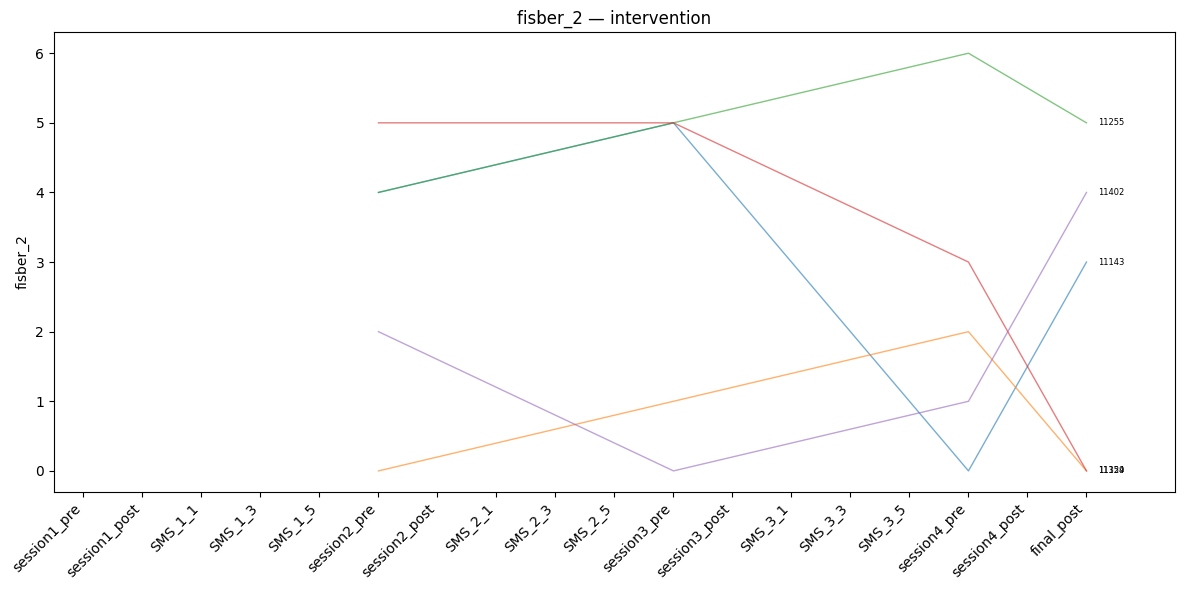

Worsened trajectories:


,part_id,timepoint,fisber_2
0,11255,session2_pre,4.0
1,11255,session3_pre,5.0
2,11255,session4_pre,6.0
3,11255,final_post,5.0
4,11402,session2_pre,2.0
5,11402,session3_pre,0.0
6,11402,session4_pre,1.0
7,11402,final_post,4.0



── fisber_3  |  Condition: control ──


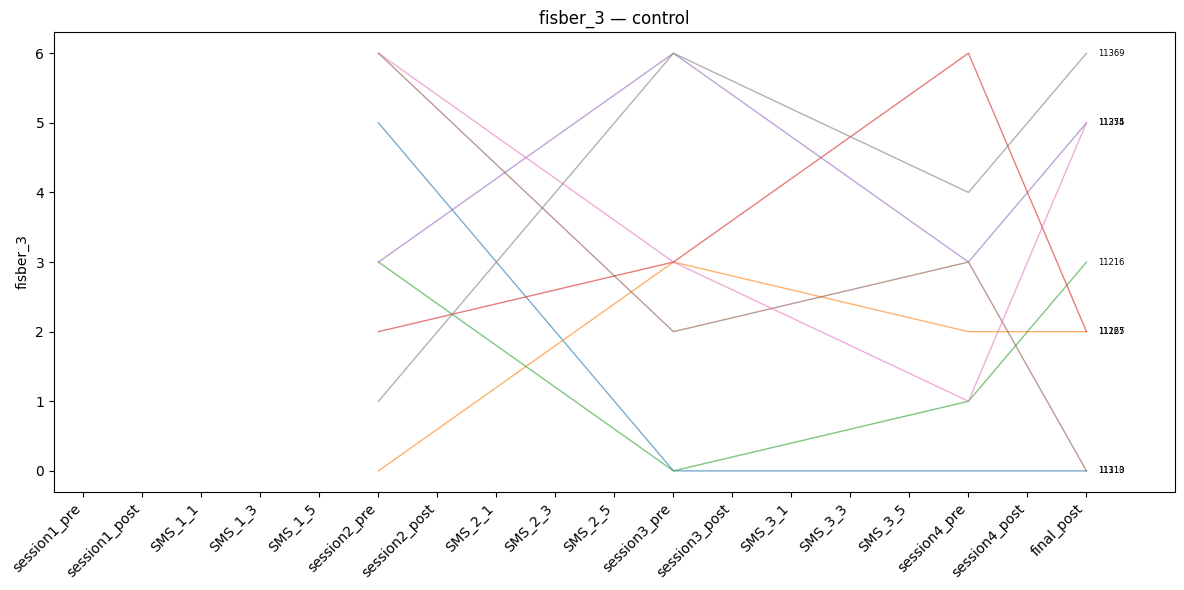

Worsened trajectories:


,part_id,timepoint,fisber_3
0,11165,session2_pre,0.0
1,11165,session3_pre,3.0
2,11165,session4_pre,2.0
3,11165,final_post,2.0
4,11275,session2_pre,3.0
5,11275,session3_pre,6.0
6,11275,session4_pre,3.0
7,11275,final_post,5.0
8,11369,session2_pre,1.0
9,11369,session3_pre,6.0



── fisber_3  |  Condition: intervention ──


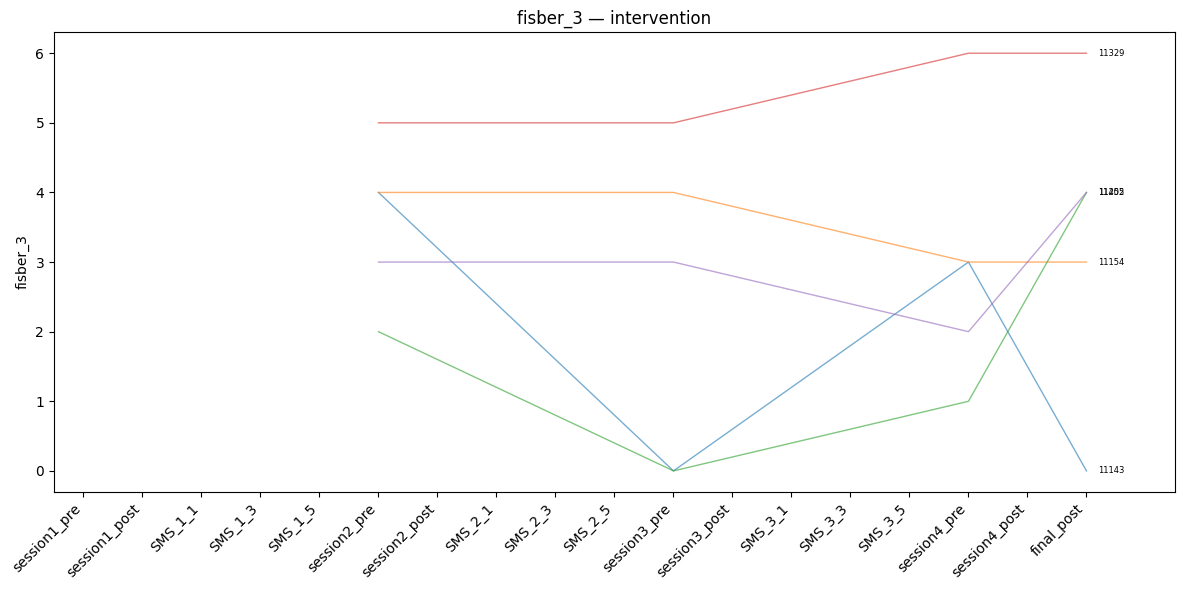

Worsened trajectories:


,part_id,timepoint,fisber_3
0,11255,session2_pre,2.0
1,11255,session3_pre,0.0
2,11255,session4_pre,1.0
3,11255,final_post,4.0
4,11329,session2_pre,5.0
5,11329,session3_pre,5.0
6,11329,session4_pre,6.0
7,11329,final_post,6.0
8,11402,session2_pre,3.0
9,11402,session3_pre,3.0



── bai_sum  |  Condition: control ──


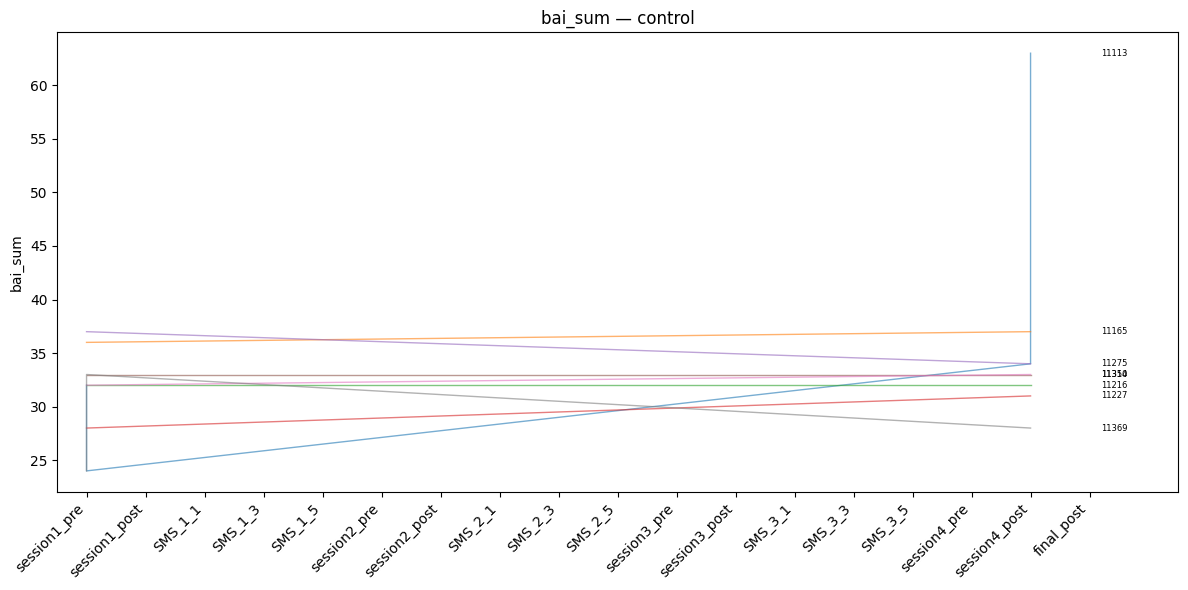

Worsened trajectories:


,part_id,timepoint,bai_sum
0,11113,session1_pre,32.0
1,11113,session1_pre,24.0
2,11113,session4_post,34.0
3,11113,session4_post,63.0
4,11165,session1_pre,36.0
5,11165,session4_post,37.0
6,11227,session1_pre,28.0
7,11227,session4_post,31.0
8,11354,session1_pre,32.0
9,11354,session4_post,33.0



── bai_sum  |  Condition: intervention ──


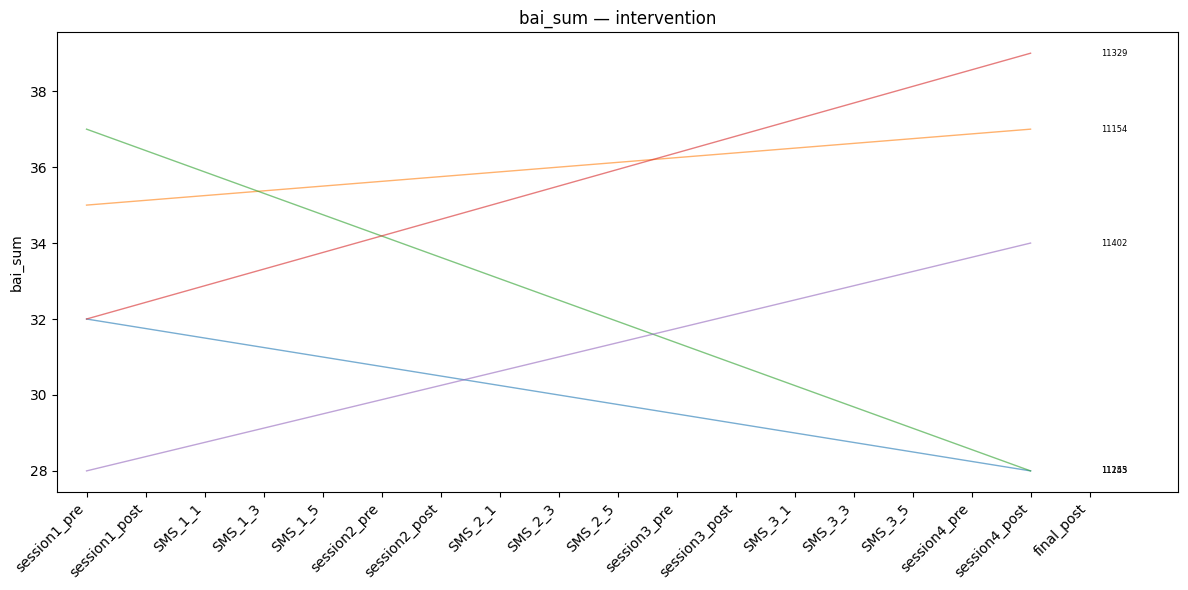

Worsened trajectories:


,part_id,timepoint,bai_sum
0,11154,session1_pre,35.0
1,11154,session4_post,37.0
2,11329,session1_pre,32.0
3,11329,session4_post,39.0
4,11402,session1_pre,28.0
5,11402,session4_post,34.0



── bdi_sum  |  Condition: control ──


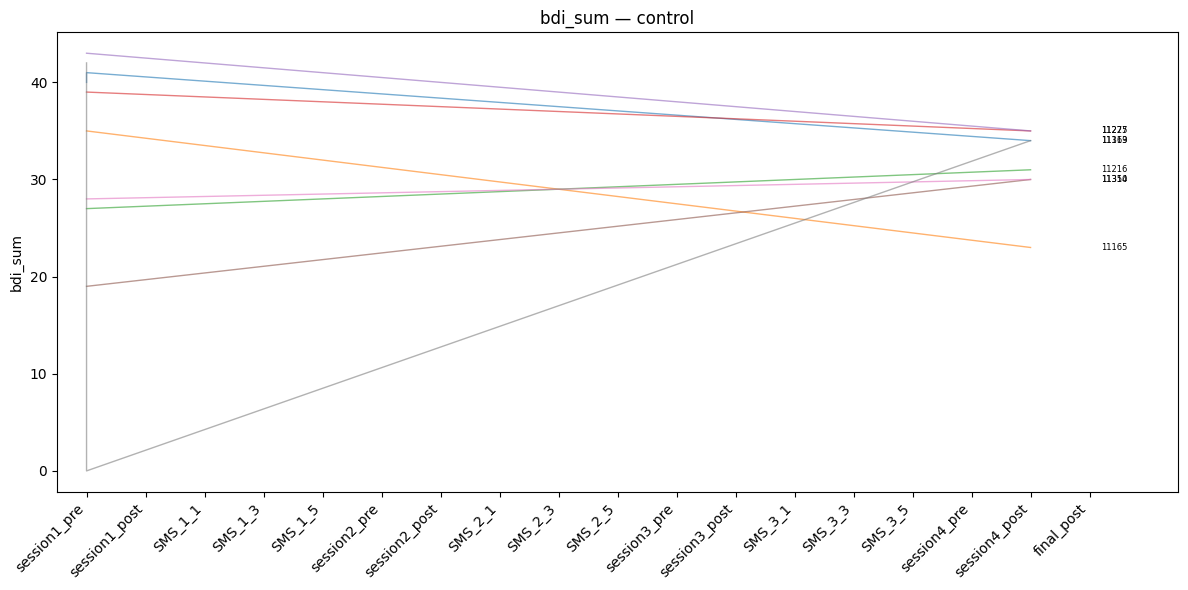

Worsened trajectories:


,part_id,timepoint,bdi_sum
0,11216,session1_pre,27.0
1,11216,session4_post,31.0
2,11310,session1_pre,19.0
3,11310,session4_post,30.0
4,11354,session1_pre,28.0
5,11354,session4_post,30.0



── bdi_sum  |  Condition: intervention ──


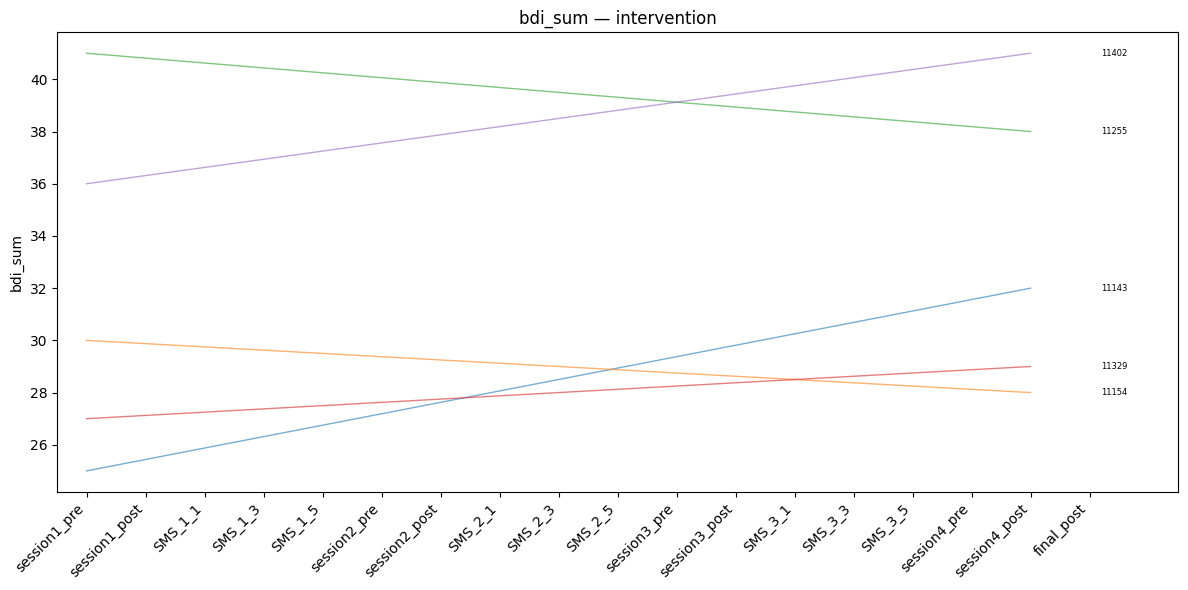

Worsened trajectories:


,part_id,timepoint,bdi_sum
0,11143,session1_pre,25.0
1,11143,session4_post,32.0
2,11329,session1_pre,27.0
3,11329,session4_post,29.0
4,11402,session1_pre,36.0
5,11402,session4_post,41.0



── MADRS_S_sum  |  Condition: control ──


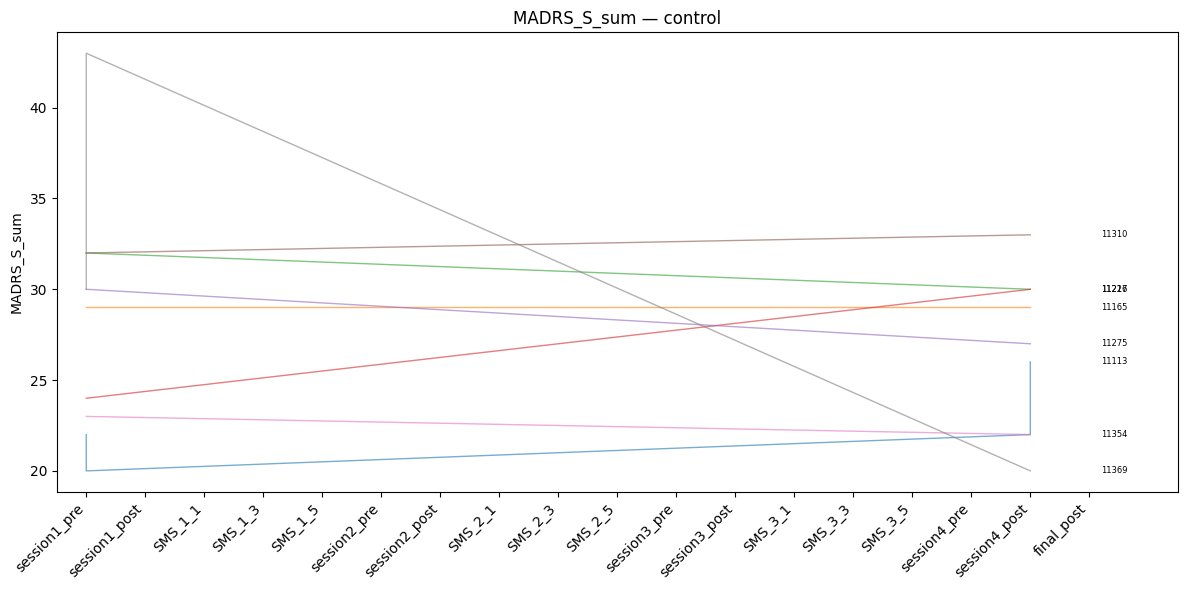

Worsened trajectories:


,part_id,timepoint,MADRS_S_sum
0,11113,session1_pre,22.0
1,11113,session1_pre,20.0
2,11113,session4_post,22.0
3,11113,session4_post,26.0
4,11227,session1_pre,24.0
5,11227,session4_post,30.0
6,11310,session1_pre,32.0
7,11310,session4_post,33.0



── MADRS_S_sum  |  Condition: intervention ──


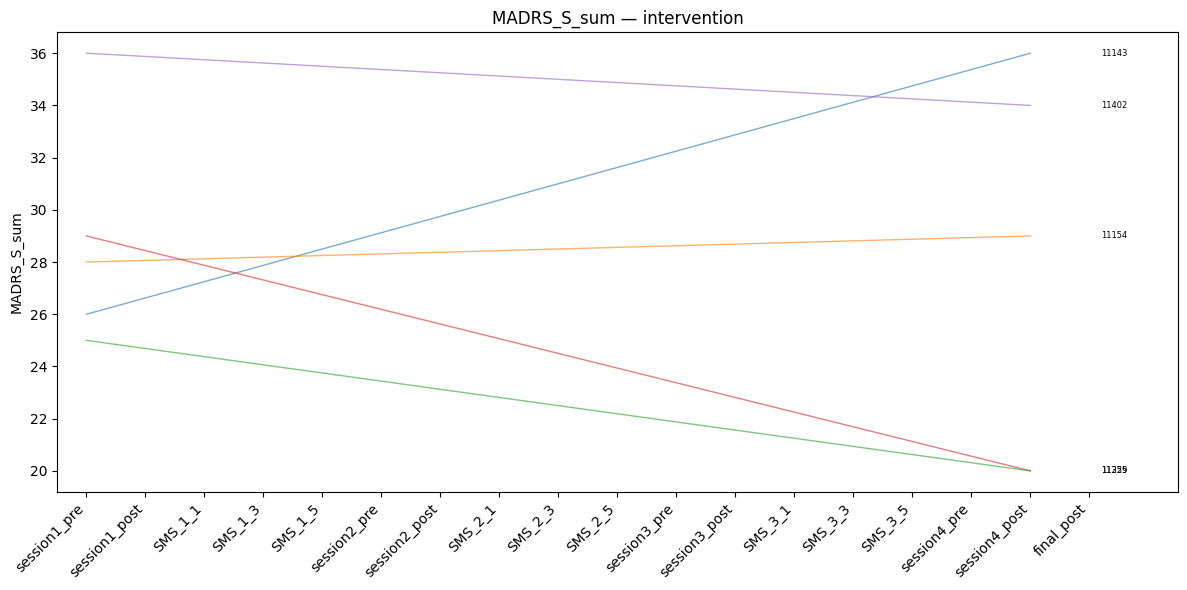

Worsened trajectories:


,part_id,timepoint,MADRS_S_sum
0,11143,session1_pre,26.0
1,11143,session4_post,36.0
2,11154,session1_pre,28.0
3,11154,session4_post,29.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 2) LOAD ALL WELLBEING CSVS
#####
df_s1_pre     = pd.read_csv(find_csv('pre_session_1'),     dtype=str)
df_s2to4_pre  = pd.read_csv(find_csv('pre_sessions_2-4'),  dtype=str)
# note: post_sessions_1-3 covers sessions 2-4 post
df_s2to4_post = pd.read_csv(find_csv('post_sessions_1-3'), dtype=str)
df_s4_post    = pd.read_csv(find_csv('post_session_4'),    dtype=str)
df_sms        = pd.read_csv(find_csv('sms_day1,3,5'),      dtype=str)
df_final      = pd.read_csv(find_csv('sms_post'),          dtype=str)

all_dfs = [df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post, df_sms, df_final]

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
import re
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
temp_dfs = [df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post]
for df in temp_dfs:
    if 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')
# session_n & sms_n for SMS
for col in ('session_n','sms_n'):
    if col in df_sms.columns:
        df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')
# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    # strip whitespace
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
df_s1_pre    ['timepoint'] = 'session1_pre'
df_s2to4_pre ['timepoint'] = df_s2to4_pre .apply(lambda r: f"session{r.session_n}_pre",  axis=1)
df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
df_s4_post   ['timepoint'] = 'session4_post'
df_sms       ['timepoint'] = df_sms      .apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP QUALTRICS-JSON ARTIFACT (keep only numeric part_id)
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (INNER JOIN to keep only actual participants)
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)
df_long = df_long.merge(
    assign[['part_id','condition']],
    on='part_id',
    how='inner'
)

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_3','SMS_1_5',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_3','SMS_2_5',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_3','SMS_3_5',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum','spane_n','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
}
bad_if_lower = {'spane_p','m3vas_mood','m3vas_pleasure'}

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    for cond, dfc in df_long.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]) \
                   .sort_values('timepoint')
            if s.empty:
                continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final + 0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final + 1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout()
        plt.show()

        # Flag worsened participants
        worsened = []
        for pid, grp in dfc.groupby('part_id'):
            seq = (grp
                   .dropna(subset=['timepoint', measure])
                   .sort_values('timepoint')[measure]
                   .astype(float))
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            df_flagged = (
                dfc[dfc['part_id'].isin(worsened)]
                  .loc[:, ['part_id','timepoint', measure]]
                  .dropna(subset=[measure])
                  .sort_values(['part_id','timepoint'])
                  .reset_index(drop=True)
            )
            print("Worsened trajectories:")
            display(df_flagged)
        else:
            print("No worsening in this condition.")

#####
# 15) RUN PLOTS FOR ALL MEASURES
#####
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_and_flag_by_condition(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [39]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)


Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                tol_sd_all  \
timepoint    session2_post session3_post session4_post session2_post   
condition                                                              
control               0.75           1.0          1.12          1.75   
intervention          0.20           0.4          0.20          0.45   

                                          
timepoint    session3_post session4_post  
condition                                 
control               1.85          1.89  
intervention          0.89          0.45

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero                             tol_sd_nonzero  \
timepoint       session2_post session3_post session4_post  session2_post   
condition                                                                  
control                   3.0           4.0           3.0            2.0   
intervention              1.0           2.0           1.0            0.0   

                                         n_side_effects                \
timepoint    session3_post session4_post  session2_post session3_post   
condition                                                               
control                0.0          1.63            2.0           2.0   
intervention           0.0          0.00            1.0           1.0   

                            
timepoint    session4_post  
condition                   
control                3.0  
intervention           1.0